# `fmri-2`: Confounds and preprocessing

This lab explores some common confounds, then introduces additional (pre)processing steps sometimes implemented after fMRIPrep: spatial smoothing, temporal filtering, and confound regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Part 1: Visualizing confounds
In the following exercises, we'll examine confounds and preprocessing for an open dataset accompanying the [Princeton Handbook for Reproducible Neuroimaging](https://brainhack-princeton.github.io/handbook/) where a single subject was listening to a spoken story ([Nastase et al., 2020](https://doi.org/10.5281/zenodo.3677089)). These data have been preprocessed using fMRIPrep ([Esteban et al., 2019](https://doi.org/10.1038/s41592-018-0235-4)); i.e. volume registration, slice-timing correction, susceptibility distortion correction, spatial normalization. First, we'll load in the confound time series output by fMRIPrep and extract the head motion parameters computed during volume registration.

In [2]:
from pandas import read_table

confounds_f = 'sub-001_ses-01_task-faces_run-1_desc-confounds_timeseries.tsv'
df = read_table(confounds_f, sep='\t')

hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = df[hm_labels].values

Create head motion figure with two subplots: one containing the translation time series and one containing the rotation time series.

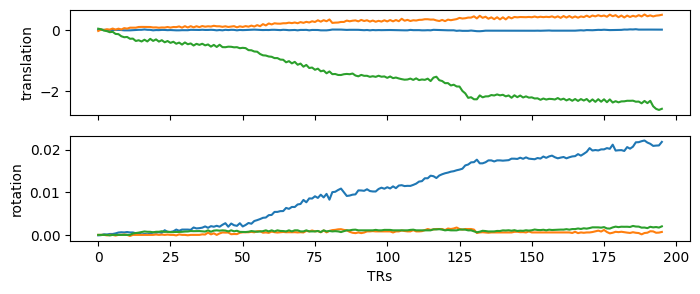

In [3]:
# Plot head motion parameters
fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)
axs[0].plot(hm[:, :3])
axs[0].set_ylabel('translation')
axs[1].plot(hm[:, 3:])
axs[1].set_ylabel('rotation')
axs[1].set_xlabel('TRs')
plt.show()

We'll load in the preprocessed BOLD data with an accompanying brain mask. Both the BOLD data and the mask have been spatially normalized to MNI space (the `MNI152NLin2009cAsym` or [ICBM 2009c Nonlinear Asymmetric](https://nist.mni.mcgill.ca/icbm-152-nonlinear-atlases-2009/) template; read more [here](https://www.lead-dbs.org/about-the-mni-spaces/)).

In [4]:
import nibabel as nib

bold_f = 'sub-001_ses-01_task-faces_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
bold = nib.load(bold_f).get_fdata()

mask_f = 'sub-001_ses-01_task-faces_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
mask = nib.load(mask_f).get_fdata().astype(bool)

Use the mask to extract BOLD data from within the brain.

In [5]:
# Extract brain data using mask
bold_brain = bold[mask]

Finally, use `imshow` to create a carpet plot with time (TRs) on the _x_-axis and all brain voxels on the _y_-axis. Use `zscore` to normalize each voxel time series prior to plotting. You may want to use `aspect='auto'` to adjust the width of the carpet plot, and `vmin`/`vmax` to adjust the range of colors.

In [6]:
from scipy.stats import zscore

bold_brain_zscore = zscore(bold_brain, axis=1)
bold_brain_zscore.shape

(51807, 196)

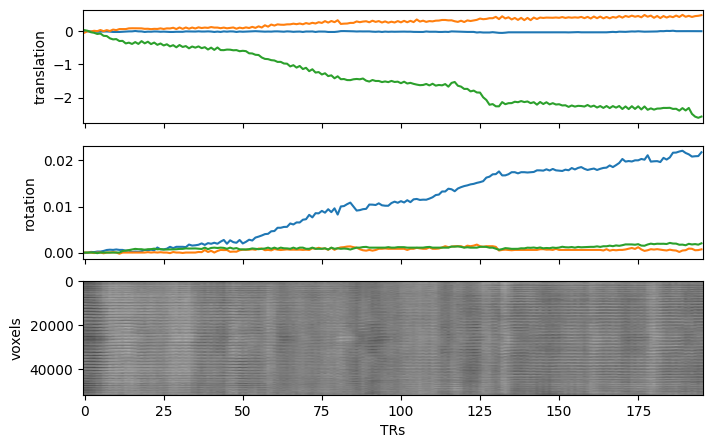

In [7]:
# Create carpet plot
fig, axs = plt.subplots(3, 1, figsize=(8, 5), sharex=True)
axs[0].plot(hm[:, :3])
axs[0].set_ylabel('translation')
axs[1].plot(hm[:, 3:])
axs[1].set_ylabel('rotation')
axs[2].imshow(bold_brain_zscore, aspect='auto',
              cmap='binary_r', vmin=-2, vmax=2)
axs[2].set_ylabel('voxels')
axs[2].set_xlabel('TRs')
plt.show()

### Part 2: Spatial smoothing

Often fMRI data are spatially smoothed prior to analysis. The extent of spatial smoothing will be depend on your analysis of interest. For exmaple, smoothing may be more appropriate for group-level analysis, and less appropriate for fine-grained pattern analyses. Smoothing can be accomplished with a number of functions. Volumetric smoothing can be performed with e.g. `nilearn` ([nilearn.image.smooth_img](https://nilearn.github.io/modules/generated/nilearn.image.smooth_img.html#nilearn.image.smooth_img)) or AFNI ([3dBlurInMask](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurInMask.html) or [3dBlurToFWHM](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurToFWHM.html)).

Smoothing cortical data on the surface may better respect the spatial relationships among cortical data, and can be done with AFNI ([SurfSmooth](https://afni.nimh.nih.gov/pub/dist/doc/program_help/SurfSmooth.html)) or FreeSurfer ([mri_fwhm](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_fwhm) and [mri_surf2surf](http://freesurfer.net/fswiki/mri_surf2surf)); see [here](https://github.com/snastase/smoothing-afni) for brief demo of AFNI smoothing.

### Part 3: Temporal filtering

To remove low frequency drifts in the fMRI signal, we often high-pass filter the time series during data analysis. This can be performed in a number of ways, but thankfully `nilearn` makes this very easy for us. The appropriate frequency cutoff may depend on your particular experiment, but standard default values are 1/100 (0.01) Hz, 1/128 Hz (0.0078), and 1/200 (0.005) Hz. We'll also standardize the time series to percent signal change ([Chen et al. 2017](https://doi.org/10.1016/j.neuroimage.2016.09.066)). Ideally, we will include temporal filtering in the same regression model as our other confounds ([Lindquist et al., 2019](https://doi.org/10.1002/hbm.24528)), but here we do it separately for didactic purposes. Use `nilearn`'s `clean` function to high-pass filter the data at 1/128 Hz; you can detrend the data and convert to percent-signal-change in the same function (note that you may need to transpose your masked brain data).

In [8]:
from nilearn.signal import clean

tr = 1.5
high_pass = 1/128
               
# Use clean to apply high-pass filter
bold_brain_clean = clean(
    bold_brain, 
    detrend=True, 
    standardize='psc', 
    high_pass=high_pass, 
    t_r=tr,
)

### Part 4: Confound regression 

Nuisance regressors describe additional timeseries we will include in our design matrix that will control for sources of noise in our data. Noise sources might include scanner artifact (e.g. drifts), motion artifact, and respiratory artifact.

#### Head motion
We already examined the most important source of noise: motion. We can effectively mitigate first-order motion effects (i.e. artifact immediately following a movement) using motion regressors. Motion regressors are estimates of the brain's movement in six directions (left/right, forward/backward, up/down, pitch, yaw, roll) over the course of the scan.

#### Motion censoring
With large movements, we might decide that a particular volume is suspect. In other words, if a participant moves their head too much, our motion regressors may not be able to compensate for signal deviations. In such instances, it may be preferable to use "motion scrubbers". These are nuisance regressors that are columns of zeros *except* for the infected volume, where a 1 is inserted instead. These act to effectively remove entirely the influence of that volume from the regression.

The threshold for what constitutes a large movement is not set in stone. For children or psychiatric patients, we expect more motion than "healthy" controls. Thankfully some guidelines have been put forward (e.g. [Power et al. 2014](https://doi.org/10.1016/j.neuroimage.2013.08.048)). A rough threshold is to reject any volume with a framewise displacement value above 0.5 mm. This may need to be adjusted depending on the level of motion of the participant (of course, if a participant is moving a lot it is better just to throw away their data!). If 10%-20% of a participant's data is going to be rejected even with a liberal threshold (e.g. FD = 1.0 mm), it may be better to exclude that participant entirely.

Below, we extract the framewise displacement time series and set a conservative threshold of 0.2. Plot the framewise displacement time series with a horizontal line marking the threshold, as well as vertical lines indicating any censored time points.

7 bad volumes


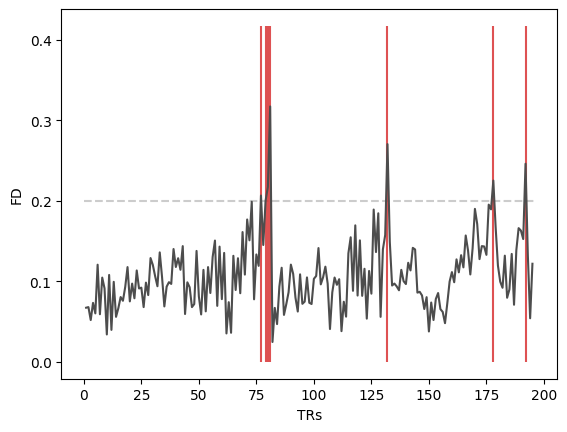

In [9]:
# Define FD threshold
fd_threshold = 0.2

# Extract framewise displacement
fd = df['framewise_displacement'].values

# Identify bad volumes
bad_vols = np.argwhere(fd > fd_threshold).ravel()
n_bad = bad_vols.shape[0]
print(f'{n_bad} bad volumes')

# Construct scrubbers
scrubber = np.zeros((fd.shape[0], n_bad))
scrubber[bad_vols, np.arange(n_bad)] = 1

# Plot the FD
plt.plot(fd, c='.3')
plt.hlines(fd_threshold, 0, 
          fd.shape[0], colors='.8',
          linestyle='--', zorder=-1)
plt.vlines(bad_vols, 0, np.nanmax(fd) + .1, 
          colors='tab:red',
          zorder=0, alpha=.8)
plt.xlabel('TRs')
plt.ylabel('FD')
plt.show()

#### CompCor regressors

To remove physiological noise (e.g. respiration), some data-driven methods have been developed that come standard in fMRIPrep. One such example is component based noise correction method (CompCor) ([Behzadi et al. 2007](https://doi.org/10.1016/j.neuroimage.2007.04.042)). Anatomical CompCor (aCompCor) attempts to estimate physiological noise from regions of the brain where we can be certain there is little-to-no neural activity (e.g. cerebrospinal fluid, white matter). The timecourses from these regions are extracted and passed through a semi-supervised dimensionality reduction processes. Plot the aCompCor variables loaded below.

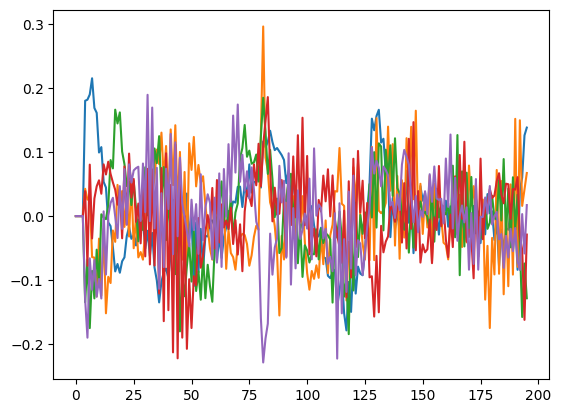

In [10]:
# Extract 5 anatomical CompCor signals
acompcor_n = 5
acompcor_labels = [f'a_comp_cor_0{n}' for n in range(acompcor_n)]
acompcor = df.filter(acompcor_labels).values

# Plot aCompCor regressors
plt.plot(acompcor)
plt.show()

#### Regression
To avoid reintroducing artifacts, we should combine our high-pass filter, de-trending, and confounds into a single regression equation ([Lindquist et al., 2019](https://doi.org/10.1002/hbm.24528)). For some types of data, e.g. resting-state or some naturalistic paradigms, there's no obvious experimental event structure and we really just want to clean up the data—like in this example. However, for traditional experiments with blocks or events, we would want to combine these confound regressors with our *regressors of interest* and fit a single model with both. Stack the head motion parameters, censor time series, and aCompCor time series into columns and re-run `clean` supplying these confound variables to the `confounds` argument. Plot an example voxel time series after confound regression.

/tmp/ipykernel_3255006/3857788610.py:5: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  bold_brain_clean = clean(


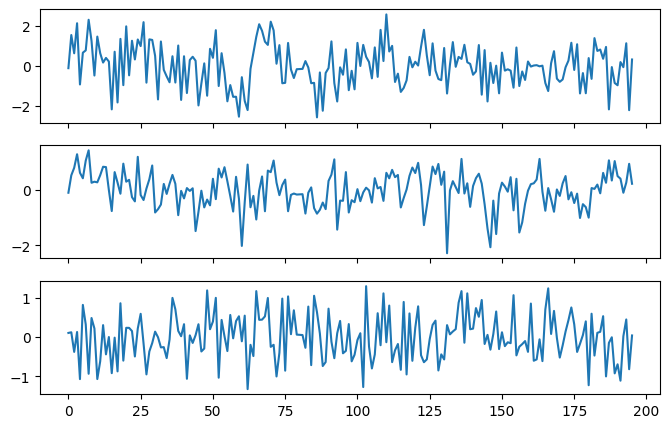

In [11]:
# Column-stack confound variables
confounds_variables = np.column_stack((hm, scrubber, acompcor))

# Re-run confound regression with high-pass filter
bold_brain_clean = clean(
    bold_brain.T, 
    confounds=confounds_variables, 
    etrend=True,
    high_pass=high_pass, 
    standardize='psc', 
    t_r=tr
)

# Plot an arbitrary voxel time series
fig, axs = plt.subplots(3, 1, figsize=(8, 5), sharex=True)
axs[0].plot(bold_brain_clean[:, 100])
axs[1].plot(bold_brain_clean[:, 500])
axs[2].plot(bold_brain_clean[:, 1000])
plt.show()

#### References

* Behzadi, Y., Restom, K., Liau, J., & Liu, T. T. (2007). A component based noise correction method (CompCor) for BOLD and perfusion based fMRI. _NeuroImage_, _37_(1), 90–101. https://doi.org/10.1016/j.neuroimage.2007.04.042

* Chen, G., Taylor, P. A., & Cox, R. W. (2017). Is the statistic value all we should care about in neuroimaging? _NeuroImage_, _147_, 952-959. https://doi.org/10.1016/j.neuroimage.2016.09.066

* Esteban, O., Markiewicz, C. J., Blair, R. W., Moodie, C. A., Isik, A. I., Erramuzpe, A., Kent, J. D., Goncalves, M., DuPre, E., Snyder, M., Oya, H., Ghosh, S. S., Wright, J., Durnez, J., Poldrack, R. A., & Gorgolewski, K. J. (2019). fMRIPrep: a robust preprocessing pipeline for functional MRI. _Nature Methods_, _16_, 111–116. https://doi.org/10.1038/s41592-018-0235-4

* Lindquist, M. A., Geuter, S., Wager, T. D., & Caffo, B. S. (2019). Modular preprocessing pipelines can reintroduce artifacts into fMRI data. _Human Brain Mapping_, _40_(8), 2358–2376. https://doi.org/10.1002/hbm.24528

* Nastase, S. A., Mennen, A. C., Brooks, P. P., & McDevitt E. A. (2020). Princeton Handbook for Reproducible Neuroimaging: Sample Data. _Zenodo_. https://doi.org/10.5281/zenodo.3677089

* Power, J. D., Mitra, A., Laumann, T. O., Snyder, A. Z., Schlaggar, B. L., & Petersen, S. E. (2014). Methods to detect, characterize, and remove motion artifact in resting state fMRI. _NeuroImage_, _84_, 320–341. https://doi.org/10.1016/j.neuroimage.2013.08.048